# 2025-11-21 PDE 2D Exercise

We will implement a PDE simulation of the [heat equation](https://en.wikipedia.org/wiki/Heat_equation).
At various points in this exercise, you will have the ability to modify the code to explore different variations on the project.

## The math

We will consider a perfectly insulated plate of metal with various conditions along each edge.
We will consider the temperature change in 2D for this exercise.

The partial differential equation which governs the movement of the heat through this plate is given by

$$ \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} $$

where $u \left( \mathbf{x}, t \right)$ is the function giving the temperature of the plate at location $\mathbf{x}$ and time $t$.

Note that $\Delta u$ or $\nabla^2 u$ is sometimes used in place of $\partial^2 u / \partial x^2 + \partial^2 u / \partial y^2$.

For this to work, we also need an initial condition $u_0 \left( \mathbf{x} \right) = u \left( \mathbf{x}, 0 \right)$ and boundary conditions.
For simplicity (and [without loss of generality](https://en.wikipedia.org/wiki/Without_loss_of_generality)), we assume $x \in \left[ 0, 1 \right]$ and $y \in \left[ 0, 1 \right]$ ($\mathbf{x} \in \left[ 0, 1 \right]^2$).
We will also need boundary conditions for the top, bottom, left, and right edges of the plate.

### Extension

For simplicity, we consider boundary conditions that do not vary with time, but this is an area for exploration.

### Note

This sounds just like yesterday!
What is different?
We will use the Finite Element Method instead of the Finite Difference Method.

maximum(u_0) = 1.0


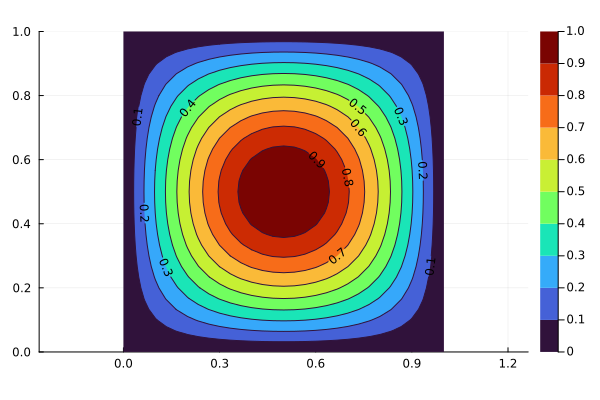

In [1]:
using Plots

# Our points x
n_1d = 31
function make_grid(x_0, x_f, y_0, y_f, n)
    # 1D spacing
    x_1d = LinRange(x_0, x_f, n)
    y_1d = LinRange(y_0, y_f, n)
    # and build coordinate pairs
    x = zeros(n * n, 2)
    for i in 1:n
        x[(i-1)*n+1 : i*n, 1]  = x_1d
        x[(i-1)*n+1 : i*n, 2] .= y_1d[i]
    end
    x_1d, y_1d, x
end
x_1d, y_1d, x = make_grid(0, 1, 0, 1, n_1d)

# An initial condition
u_0 = sin.(x[:, 1] * π) .* sin.(x[:, 2] * π)
@show maximum(u_0)

# And plot it
contourf(x_1d, y_1d, u_0, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar_ticks=(0:11, LinRange(0, 1, 11)))

## New(ish) wrinkle

We now need to handle 2D spatial derivatives.
Fortunately, this is a natural extension of our 1D spatial derivatives.

We will use the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) here.

We have seen the finite difference approximations of derivatives before.
For this exercise, we will need a forward and backward difference for the first derivative and a centered difference for the second derivative.

$$ \begin{split}
  f'  \left( x \right) &\approx \frac{f \left( x + h \right) - f \left( x \right)}{h} \\
  f'  \left( x \right) &\approx \frac{f \left( x \right) - f \left( x + h \right)}{h} \\
  f'' \left( x \right) &\approx \frac{f \left( x - h \right) - 2 f \left( x \right) + f \left( x + h \right)}{h^2}
\end{split} $$
Instead of making the matrix itself, we will make a function that applies the action of this matrix.

$$ u'' \left( x_n \right) \approx \frac{u \left( x_{n - 1} \right) - 2 u \left( x_n \right) + u \left( x_{n + 1} \right)}{h^2} $$

We will make a separate function for handling boundary conditions.

In [2]:
# Let's make a function that applies the matrix A on the interior of the plate
function diffusion_interior(u_0)
    u_next = zeros(size(u_0))
    h = 1 / n_1d # Note that I'm getting this from global space
    # Compute derivatives
    for j in 2:n_1d-1     # y
        for i in 2:n_1d-1 # x
            u_next[i + n_1d*(j - 1)] = (
                u_0[(i - 1) + n_1d*(j - 1)] +
                u_0[(i + 1) + n_1d*(j - 1)] +
                u_0[i + n_1d*(j - 2)] +
                u_0[i + n_1d*(j + 0)] -
                4 * u_0[i + n_1d*(j - 1)]
            ) / h^2
        end
    end
    u_next
end

display(diffusion_interior(u_0))

961-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Boundary conditions

We will start with simple boundary conditions, $u_L = u_R = 0$.

This means that $u \left( x_0 \right)$ and $u \left( x_n \right)$ never change, so we will encode this by zeroing those entries in our result vector.

In [3]:
# Boundary conditions
function zero_boundaries(u_0, u_next)
    # Zero edges of plate
    for j in [1, n_1d]  # y
        for i in 1:n_1d # x
            u_next[i + n_1d*(j - 1)] = 0
        end
    end
    for j in 1:n_1d        # y
        for i in [1, n_1d] # x
            u_next[i + n_1d*(j - 1)] = 0
        end
    end
    u_next
end

# And join them together
function dF(u_0)
    u_next = diffusion_interior(u_0)
    zero_boundaries(u_0, u_next)
end

display(dF(u_0))

961-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Time Stepper

Now we need to pick one of our for advancing our solution forward in time.
This is the area where we can experiment the most.
For now, let's use a simple [forward Euler](https://en.wikipedia.org/wiki/Euler_method).

$$ x_{n + 1} = x_n + h \, dF \left( t_n, x_n \right) $$

where $t_n$ is the current time, $x_n$ is the current solution, $h$ is our step size in time, $dF$ is our differential equation, and $x_{n + 1}$ is our new solution.

Let's code up forward Euler and take a single step.

maximum(u_1) = 0.9999789421657956


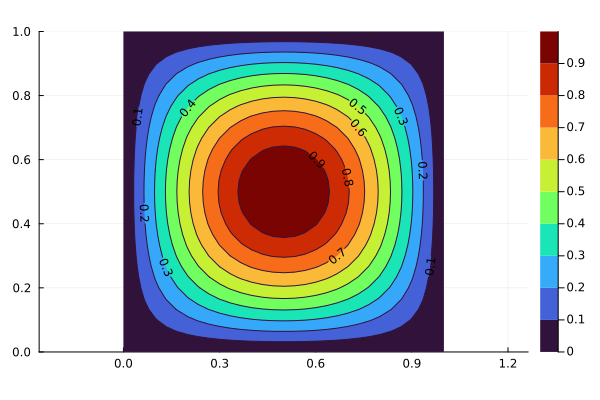

In [4]:
# Forward euler
function euler_forward(x, h, dF)
    return x + h * dF(x)
end

# And take a single step
h  = 1e-6
u_1 = euler_forward(u_0, h, dF)
@show maximum(u_1)

# And plot
contourf(x_1d, y_1d, u_1, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar_ticks=(0:11, LinRange(0, 1, 11)))

### Exploration

Implement backward Euler for this system instead.
And maybe the $\theta$ method.

## Building it out

Ok, now it seems like we need two things right now.

1) Something to take our time stepper (`euler_forward`) and our finite different matrix (`A`) and create a series of outputs.

2) Something to automate and animate the plotting process.

Let's start with 1).
We'll make a basic function `run_simulation` to produce our values $u_n$ via our PDE and time stepper.

maximum(u[end, :]) = 0.005169326243333146


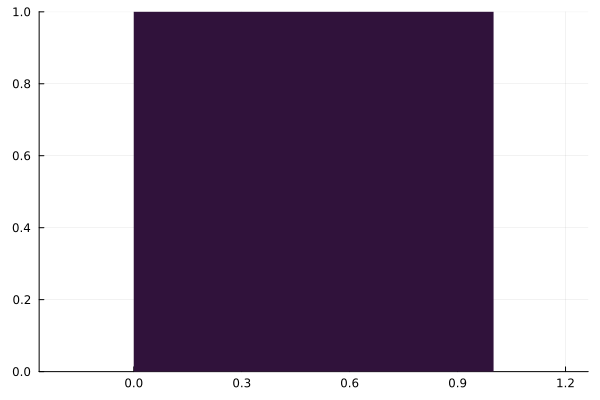

In [5]:
function run_simulation(u_0, h, dF, time_stepper, t_f)
    # Setup
    num_steps = Int(ceil(t_f / h))
    u = zeros((num_steps + 1, maximum(size(u_0))))
    u[1, :] = u_0

    # Simulate
    for i in 1:num_steps
        u[i + 1, :] = time_stepper(u[i, :], h, dF)
    end
    u
end

# And run it
h   = 1e-5
t_f = 0.25 # s
u   = run_simulation(u_0, h, dF, euler_forward, t_f)
@show maximum(u[end, :])

# Plotting the final u as a sanity check
contourf(x_1d, y_1d, u[end, :], aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar=:none)

It looks like the temperature went to $0$ on the whole plate, which I would expect given the boundary conditions.

## Pretty pictures

Lets make an animation now!

In [6]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:Int(ceil(t_f / h))
    contourf(x_1d, y_1d, u[i, :], aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar=:none)
end every 250;

[ Info: Saved animation to /home/jeremy/Documents/csci-3656-fall-2025/source/notebooks/heat_plate_fixed.gif


Plots.AnimatedGif("/home/jeremy/Documents/csci-3656-fall-2025/source/notebooks/heat_plate_fixed.gif")
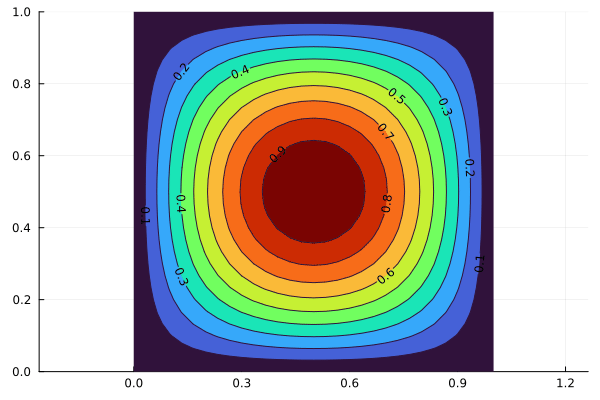

In [7]:
gif(animation, "heat_plate_fixed.gif", fps=30)

## Different initial condition

How about a more interesting initial condition?

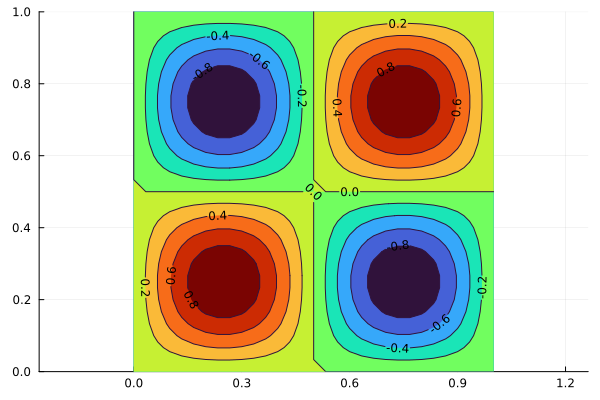

In [8]:
# Setup
h   = 1e-5
t_f = 0.25 # s
u_0 = sin.(x[:, 1] * 2π) .* sin.(x[:, 2] * 2π)

# Plotting the initial u as a sanity check
contourf(x_1d, y_1d, u_0, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(-1, 1, 11), colorbar=:none)

maximum(u_1) = 0.9889907175516975


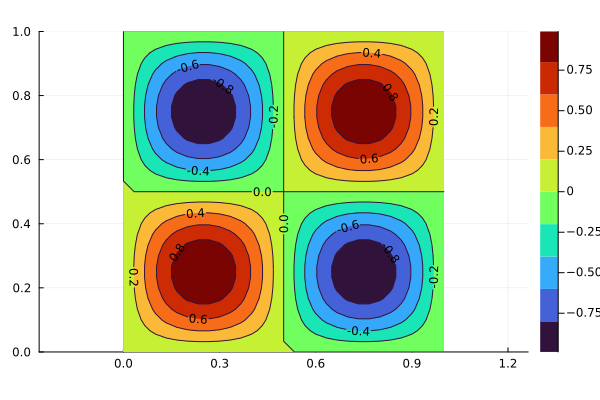

In [9]:
# And take a single step
h  = 1e-6
u_1 = euler_forward(u_0, h, dF)
@show maximum(u_1)

# And plot
contourf(x_1d, y_1d, u_1, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(-1, 1, 11), colorbar_ticks=(0:11, LinRange(0, 1, 11)))

maximum(u[end, :]) = 7.491934145799629e-10


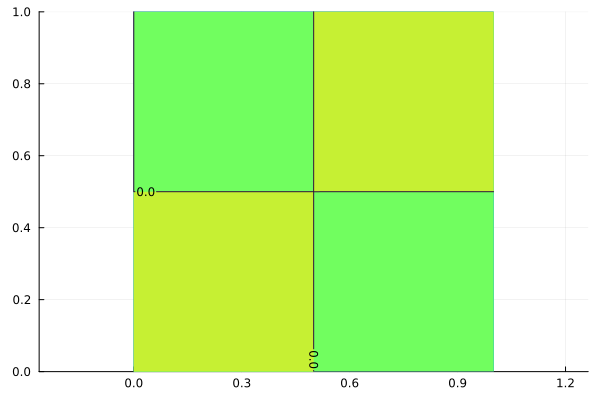

In [10]:
# Running the simulation
u = run_simulation(u_0, h, dF, euler_forward, t_f)
@show maximum(u[end, :])

# Quiet you noisy warnings!
using Logging
Logging.disable_logging(Logging.Warn)

# Plotting the initial u as a sanity check
contourf(x_1d, y_1d, u[end, :], aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(-1, 1, 11), colorbar=:none)

In [11]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:Int(ceil(t_f / h))
    contourf(x_1d, y_1d, u[i, :], aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(-1, 1, 11), colorbar=:none)
end every 250;

Plots.AnimatedGif("/home/jeremy/Documents/csci-3656-fall-2025/source/notebooks/heat_plate_zero_2.gif")
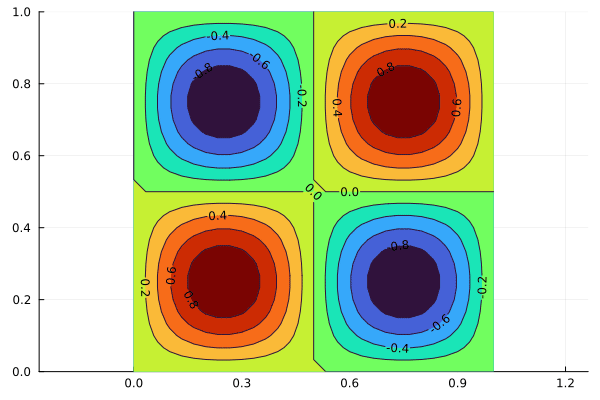

In [12]:
gif(animation, "heat_plate_zero_2.gif", fps=30)

## Periodic boundaries

Ok, let's tackle the periodic boundaries.

In this case, we can think of our solution as "wrapping around", so in our 1D finite difference equation, we will have

$$
f'' \left( x_0 \right) \approx \frac{f \left( x_n \right) - 2 f \left( x_0 \right) + f \left( x_1 \right)}{h^2}
$$

and

$$
f'' \left( x_n \right) \approx \frac{f \left( x_0 \right) - 2 f \left( x_n \right) + f \left( x_{n - 1} \right)}{h^2}
$$

maximum(u_1) = 0.9889907175516975


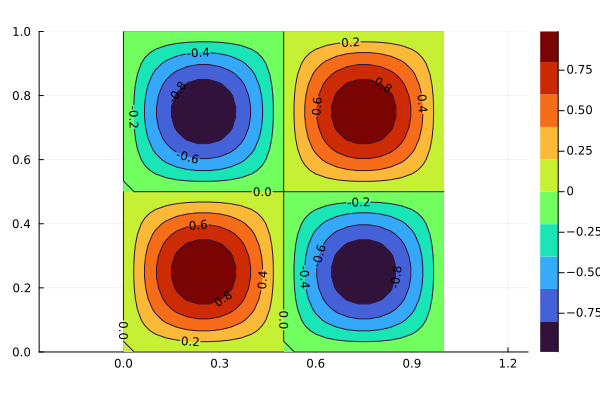

In [13]:
# Boundary conditions
function periodic_boundaries(u_0, u_next)
    h = 1 / n_1d # Note that I'm getting this from global space
    # Periodiclly map across plate edges
    for i in 2:n_1d-1 # x
        # Compute on bottom edge
        j = 1
        u_next[i + n_1d*(j - 1)] = (
            u_0[(i - 1) + n_1d*(j    - 1)] +
            u_0[(i + 1) + n_1d*(j    - 1)] +
            u_0[i       + n_1d*(n_1d - 2)] +
            u_0[i       + n_1d*(j    + 0)] -
            4 * u_0[i + n_1d*(j - 1)]
        ) / h^2
        # Copy to top edge
        u_next[i + n_1d*(n_1d - 1)] = u_next[i + n_1d*(j - 1)]
    end
    for j in 2:n_1d-1 # y
        # Compute on left edge
        i = 1
        u_next[i + n_1d*(j - 1)] = (
            u_0[(n_1d - 1) + n_1d*(j - 1)] +
            u_0[(i    + 1) + n_1d*(j - 1)] +
            u_0[i          + n_1d*(j - 2)] +
            u_0[i          + n_1d*(j + 0)] -
            4 * u_0[i + n_1d*(j - 1)]
        ) / h^2
        # Copy to right edge
        u_next[n_1d + n_1d*(j - 1)] = u_next[i + n_1d*(j - 1)]
    end
    # And the corner(s)
    i = 1
    j = 1
    u_next[i + n_1d*(j - 1)] = (
        u_0[(n_1d - 1) + n_1d*(j - 1)] +
        u_0[(i    + 1) + n_1d*(j - 1)] +
        u_0[i          + n_1d*(n_1d - 2)] +
        u_0[i          + n_1d*(j + 0)] -
        4 * u_0[i + n_1d*(j - 1)]
    ) / h^2
    u_next[n_1d + n_1d*(j - 1)] = u_next[i + n_1d*(j - 1)]
    u_next[1 + n_1d*(n_1d - 1)] = u_next[i + n_1d*(j - 1)]
    u_next[n_1d + n_1d*(n_1d - 1)] = u_next[i + n_1d*(j - 1)]
    # Return
    u_next
end

# And join them together
function dF(u_0)
    u_next = diffusion_interior(u_0)
    periodic_boundaries(u_0, u_next)
end


# And take a single step
h  = 1e-6
u_1 = euler_forward(u_0, h, dF)
@show maximum(u_1)

# And plot
contourf(x_1d, y_1d, u_1, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(-1, 1, 11), colorbar_ticks=(0:11, LinRange(0, 1, 11)))

Hmm, I see a problem here.
If the initial solution has an average temperature of 0, then we will do extra work to repeat the final result above.

We need to swap the initial condition so we can actually see the effect of this boundary condition.

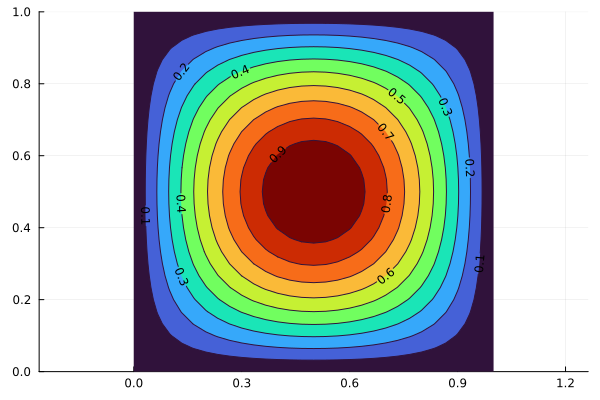

In [14]:
# Setup
h   = 1e-5
t_f = 0.25 # s
u_0 = sin.(x[:, 1] * π) .* sin.(x[:, 2] * π)

# Plotting the initial u as a sanity check
contourf(x_1d, y_1d, u_0, aspect_ratio=:equal, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar=:none)

maximum(u[end, :]) = 0.40455907051979945


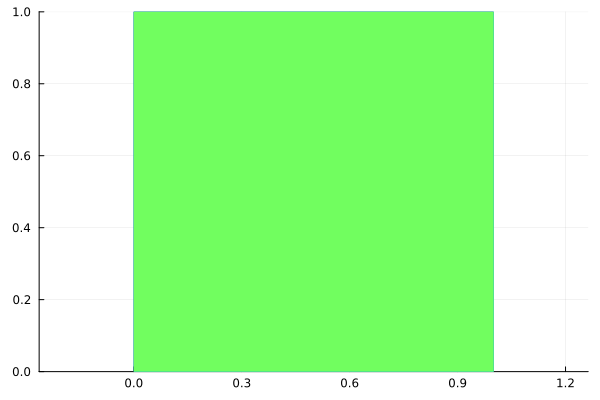

In [15]:
# Running the simulation
u = run_simulation(u_0, h, dF, euler_forward, t_f)
@show maximum(u[end, :])

# Plotting the final u as a sanity check
contourf(x_1d, y_1d, u[end, :], aspect_ratio=:true, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar=:none)

In [16]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:Int(ceil(t_f / h))
    contourf(x_1d, y_1d, u[i, :], aspect_ratio=:true, clabels=true, color=:turbo, levels=LinRange(0, 1, 11), colorbar=:none)
end every 250;

Plots.AnimatedGif("/home/jeremy/Documents/csci-3656-fall-2025/source/notebooks/heat_plate_periodic.gif")
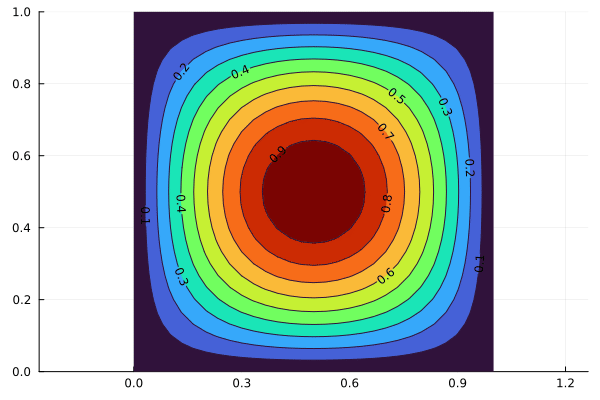

In [17]:
gif(animation, "heat_plate_periodic.gif", fps=30)

## Extensions

There are several ways we can extend this work.

- Time Stepper: An implicit time stepper would allow us to take bigger timesteps.

- Fixed Point Solver: Our fixed point solver this week is terrible.
Can we replace it with something better?

- Boundary Conditions: Time varying boundary conditions would be interesting to investigate.

- Initial Condition: What happens if we change the initial conditions (such as using an initial condition with a discontinuity when using the periodic boundary conditions)?

- Recreation: We can see a hoof shaped region of high initial head on the demo gif shown on [Wikipedia](https://en.wikipedia.org/wiki/Heat_equation).
Can you recreate that simulation (or another one you find)?

- Finite Elements: We have used FDM (Finite Difference Method).
See the "bonus content" notebook for a brief intro to using FEM (Finite Element Method) instead.